In [ ]:
import re
import requests
import googleapiclient
from googleapiclient.discovery import build
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from rsa.pkcs1 import key

API_KEY = ''
URL = 'https://www.googleapis.com/youtube/v3/search'

## Check daily quota

In [ ]:
# check whether we've run out of daily quota amount from the API
def check_daily_limit():
  params = {
      'part': 'snippet',
      'q': ['Israel Palestine Conflict','Israel','Gaza','Palestine'],
      'type': 'video',
      'key': API_KEY,
      'maxResults': 1,
      'order':'relevance',
  }
  response = requests.get(URL, params=params)
  if response.status_code == 200:
      print("Quota not exceeded")
      return response.json()
  else:
      print(f"Error: {response.status_code}")
      print(response.text)
response1=check_daily_limit()

# Get Playlist videos

In [ ]:
# duration_conversion to seconds by William
def duration_conversion(duration):
    import re
    match = re.match('PT(\d+H)?(\d+M)?(\d+S)?', duration)

    if match!=None:
      hours = int(match.group(1)[:-1]) if match.group(1) else 0
      minutes = int(match.group(2)[:-1]) if match.group(2) else 0
      seconds = int(match.group(3)[:-1]) if match.group(3) else 0
      return hours * 3600 + minutes * 60 + seconds
    else:
      print("duration pattern not matched")
      return None

In [ ]:
def fetch_playlist(playlist_id):
  youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=API_KEY)
  next_page_token = None
  videos = []

  while True:
      request = youtube.playlistItems().list(
          part="snippet",
          playlistId=playlist_id,
          maxResults=50,
          pageToken=next_page_token
      )
      response = request.execute()
      videos.extend(response.get("items", []))

      next_page_token = response.get("nextPageToken")
      if not next_page_token:
          break

  return videos

In [ ]:
def build_csv(playlist):
  data=[]
  for k,v in playlist.items():
    videos=fetch_playlist(v)
    for video in videos:
      id = video["snippet"]["resourceId"]["videoId"]
      title = video["snippet"]["title"]
      channel = k

      call = build("youtube", "v3", developerKey=API_KEY)
      request = call.videos().list(
          part="contentDetails,statistics",
          id=id
      )
      response = request.execute()

      if "items" in response and len(response["items"]) > 0:
        video_details = response["items"][0]
        duration = video_details.get("contentDetails", {}).get("duration", "")
        duration = duration_conversion(duration)
      else:
        continue

      if (duration==None):
        continue

      data.append([channel, title, id, duration, "Video" if duration > 60 else "Short"])
      if len(data)%10 ==0 and len(data)!=0:
        print(f"Data retrieved: {len(data)} rows")

  df = pd.DataFrame(data, columns=['Channel', 'Title', 'Video ID','Duration','Type'])
  df=df.drop_duplicates(subset=["Video ID"], keep=False)
  df.to_csv(f'Israel_Palestine_Conflict_videos.csv', index=False, encoding='utf-8')
  return df

## Usage Example

In [ ]:
# Define playlist ID in dictionary
playlist = {"NBC News":"PL0tDb4jw6kPwbfkRqaiNFdr0d_rl9vAXP","CNN":"PL6XRrncXkMaU55GiCvv416NR2qBD_xbmf",
            "Fox News":"PLlTLHnxSVuIyMU4Q4I8NsLAVK1iNANGW9","CBC News":"PLeyJPHbRnGaY2w91OBmfTL-d-a6MrO0gT"}
df = build_csv(playlist)

## Define video category according to duration range

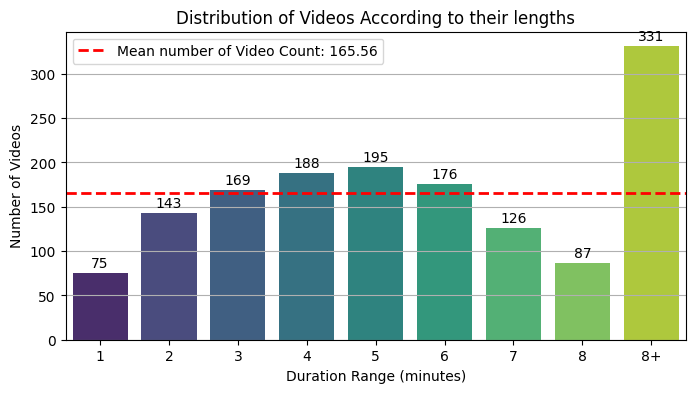

In [ ]:
def plot_df_videoDuration(df):
  bins =[int(b) for b in list(range(0, 481, 60))]+[42900]
  labels = [str(x) for x in range(1, 9)]+['8+']

  df['DurationRange'] = pd.cut(df['Duration'], bins=bins, labels=labels, right=False)

  colors = sns.color_palette('viridis', n_colors=len(labels))
  plt.figure(figsize=(8, 4))

  ax=sns.countplot(x='DurationRange', data=df, order=labels, palette=colors)
  for label, count in zip(ax.patches, df.groupby('DurationRange').size()):
      height = label.get_height()
      ax.text(
          label.get_x() + label.get_width() / 2,
          height + 3,
          f'{count}',
          ha='center',
          va='bottom'
      )
  mean_counts = df.groupby('DurationRange').size().mean()
  ax.axhline(mean_counts, color='red', linestyle='dashed', linewidth=2, label=f'Mean number of Video Count: {mean_counts:.2f}')
  plt.xlabel('Duration Range (minutes)')
  plt.ylabel('Number of Videos')
  plt.title('Distribution of Videos According to their lengths')
  ax.yaxis.grid(True)
  plt.legend()
  plt.show()

  df.drop('DurationRange', axis=1, inplace=True)

plot_df_videoDuration(df)

In [ ]:
max_count=df["Duration"].max()
min_count=df["Duration"].min()
print(f"Maximum duration in seconds: {max_count}\nMinimum duration in seconds: {min_count}")
x=len(df[df['Duration'] < 5 * 60])
y=len(df[df['Duration'] >= 5 * 60])
print(f"Videos shorter than 5 min: {x}\nVideos longer than 5 min: {y}")

Maximum duration in seconds: 42900
Minimum duration in seconds: 17
Videos shorter than 5 min: 770
Videos longer than 5 min: 721


In [ ]:
Type_definition=5 #in minutes
"""
creates a new column 'Type' based on the 'Duration' values.
If the duration is >= 5 minutes, the 'Type' is set to 'Video';
otherwise, it's set to 'Short'.
"""

df['Type'] = df['Duration'].apply(lambda duration: 'Video' if duration >= Type_definition * 60 else 'Short')
print(df['Type'].value_counts())

Short    770
Video    721
Name: Type, dtype: int64
